In [169]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import cv2
from tqdm import tqdm_notebook as tqdm

#set input, output folders
#set file name
name='H2231_SE34_EEE_SW5_CHO'
input_folder=r'\\mvm-ccns-srv2.ccns.ed.ac.uk\lcn\Francesco\BEH\analysed'
file_name=name+'DLC_resnet50_event_arena2Nov17shuffle1_300000.csv'
vid_name=name+'.flv'
lab_vid_name=name+'DLC_resnet50_event_arena2Nov17shuffle1_300000_labeled.mp4'
LED_file = os.path.join(input_folder, 'LED3.csv')
output_folder=r'\\mvm-ccns-srv2.ccns.ed.ac.uk\lcn\Francesco\BEH\output'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

led=pd.read_csv(LED_file, header=0)
led=led.iloc[1:]
led=led.reset_index(drop=True)

    #unpack information from the name

animal, session, meta, sandwell, stage_name = (name.split("_"))
session_type= session[1]
session_number=int(session[2:4])
stage=stage_name[:3]


#just in this case 
meta=meta+meta[0]


columns=  ['Time (s)','cap_x','cap_y','cap_likelihood','leftear_x','leftear_y','leftear_likelihood','rightear_x','rightear_y','rightear_likelihood','tailbase_x','tailbase_y','tailbase_likelihood']      
points_x=['cap_x','leftear_x','rightear_x','tailbase_x']
points_y=['cap_y','leftear_y','rightear_y','tailbase_y'] 
likelihoods=['cap_likelihood', 'leftear_likelihood', 'rightear_likelihood', 'tailbase_likelihood']

"""
Time isn't time now but whatever
"""
    #this reads the DLC output, removes the text columns, converts to float and assigns the column names
    
df=pd.read_csv(os.path.join(input_folder, file_name), sep=',', header=1)

df.columns=columns
df=df.iloc[1:]
df=df.reset_index(drop=True)
df=df.astype(float)

#stores original data and works on a copy
df2=df.copy()

In [170]:
led[led['Session']==session]


,Unnamed: 0,Animal,Session,Stage,Trial,Trial start frame,Trial end frame
0,1,H2231,SE34,CHO,1.0,58.0,2814.0
1,2,H2231,SE34,CHO,2.0,2923.0,5231.0
2,3,H2231,SE34,CHO,3.0,5321.0,7168.0
3,4,H2231,SE34,CHO,4.0,7264.0,9369.0


In [171]:
led=led[led['Session']==session]
led=led[led['Stage']==stage_name].reset_index(drop=True)
LED_intervals=[[ int(i) for i in led['Trial start frame'].values.tolist()],[int(i) for i in led[ 'Trial end frame'].values.tolist()]]
LED_intervals

[[58, 2923, 5321, 7264], [2814, 5231, 7168, 9369]]

In [172]:
LED_intervals[1][3]=9321

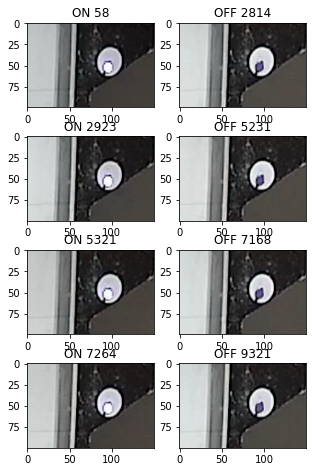

In [173]:
fig=plt.figure(figsize=(5,2*len(LED_intervals[0])))
for trial in range(len(LED_intervals[0])):
    
    
    ax = fig.add_subplot(len(LED_intervals[0]),2,2*trial+1)
    cap = cv2.VideoCapture(os.path.join(input_folder, vid_name))
    cap.set(1, LED_intervals[0][trial]+1)
    img = cap.read()[1]
    pixels = cv2.blur(img[1],(5,5))

    img = img[600:700][:,1100:1250]
    ax.set_title('ON %s' % int(LED_intervals[0][trial]))
    ax.imshow(img)   
    
    ax = fig.add_subplot(len(LED_intervals[0]),2,2*trial+2)
    cap = cv2.VideoCapture(os.path.join(input_folder, vid_name))
    cap.set(1, LED_intervals[1][trial]+1)
    img = cap.read()[1]
    pixels = cv2.blur(img[1],(5,5))

    img = img[600:700][:,1100:1250]
    ax.set_title('OFF %s' % int(LED_intervals[1][trial]))
    ax.imshow(img)   

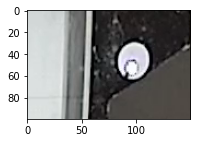

In [174]:
frame =9320
ax=plt.figure(figsize=(5,2))
cap = cv2.VideoCapture(os.path.join(input_folder, vid_name))
cap.set(1, frame+1)
img = cap.read()[1]
pixels = cv2.blur(img[1],(5,5))

img = img[600:700][:,1100:1250]
plt.imshow(img)   

In [175]:
#cleanup the points by removing lowlikelihood points, and outside-the arena points. Points are converted to NaNs

def clean_up(dataframe, points, threshold, x_min, y_max):
    #points is a list of strings
    
    for item in points:
        dataframe['%s_x' %item].mask(dataframe['%s_likelihood' %item] < threshold, np.nan, inplace=True)
        dataframe['%s_x' %item].mask(dataframe['%s_x' %item] < x_min, np.nan, inplace=True)
        dataframe['%s_x' %item].mask(dataframe['%s_y' %item] > y_max, np.nan, inplace=True)
        print("Cleaned ", item, "_x")
        
        dataframe['%s_y' %item].mask(dataframe['%s_likelihood' %item] < threshold, np.nan, inplace=True)
        dataframe['%s_y' %item].mask(dataframe['%s_x' %item] < x_min, np.nan, inplace=True)
        dataframe['%s_y' %item].mask(dataframe['%s_y' %item] > y_max, np.nan, inplace=True)
        print("Cleaned ",item,"_y")
    
    return dataframe
            
my_points = ['cap', 'rightear', 'leftear', 'tailbase']

df2=clean_up(df2, my_points, 0.9, 250, 950)

Cleaned  cap _x
Cleaned  cap _y
Cleaned  rightear _x
Cleaned  rightear _y
Cleaned  leftear _x
Cleaned  leftear _y
Cleaned  tailbase _x
Cleaned  tailbase _y


In [176]:
def edist_df(dataframe,p,q,row):
    #this function calculates the euclidean distance between selected points (p,q) e.g. 'cap' and 'leftear' for the selected row number 
    #the dataframe must contain p,q coordinates in the form 'p_x, 'p_y', 'q_x', 'q_y'
    #analogous to 
    #dataframe.apply(lambda x: dst.euclidean( [x['p_x'],x['p_y']], [x['q_x'],x['q_y']]), axis=1)

    p=[ dataframe['%s_x' %p].iloc[row] , dataframe['%s_y' %p].iloc[row] ]
    q=[ dataframe['%s_x' %q].iloc[row] , dataframe['%s_y' %q].iloc[row] ]
    value=math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(p, q)))
    return value

def d_df(df,px,py,n):
    #calculates the euclidean distance between one frame and the previous for the poin p px and py are _x and _y coordinates 
    #row=n
    p=[ df[px].iloc[n] , df[py].iloc[n] ]
    q=[ df[px].iloc[n-1] , df[py].iloc[n-1] ]
    value=math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(p, q)))
    return value

"""
assign values corresponding to the startbox positions based on meta by unpacking the session type (A/E) 
and the starting box (S,W,E,(N)) from the name of the file
"""

coordinates_dic = {
    "N":[700,10],
    "S":[700,1050],
    "W":[200,650],
    "E":[1200,400],
    }

i=0

for start in LED_intervals[0]:
    for k in range(start-25, start+25):
        df2.loc[k,points_x]=coordinates_dic[meta[i]][0]
        df2.loc[k,points_y]=coordinates_dic[meta[i]][1]
        df2.loc[k, likelihoods]=2.0
    i+=1

i=0
for end in LED_intervals[1]:
    if session_type=='A':
        box='N'
    elif session_type=='E':
        box=meta[i]
    for k in range(end-25, end+25):
        df2.loc[k,points_x]=coordinates_dic[box][0]
        df2.loc[k,points_y]=coordinates_dic[box][1]
        df2.loc[k, likelihoods]=2.0

    i+=1
    
#interpolates small NaNs stretches for cap



df2[['cap_x', 'cap_y']]=df2[['cap_x', 'cap_y']].interpolate(method='linear', limit=5)

df2['d_cap']=df2['d_Rear']=df2['d_Lear']=df2['d_tail']=df2['cap_x']*0

with tqdm(total=len(df2.index)) as pbar:
    for row in range(1,len(df2.index)):
        df2['d_cap'].iloc[row]= d_df(df2, 'cap_x','cap_y', row)
        df2['d_Rear'].iloc[row]= d_df(df2, 'rightear_x','rightear_y', row)
        df2['d_Lear'].iloc[row]= d_df(df2, 'leftear_x', 'leftear_y', row)
        df2['d_tail'].iloc[row]= d_df(df2, 'tailbase_x','tailbase_y', row)
        pbar.update(1)

<ipython-input-176-7f2d31eccd88>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(df2.index)) as pbar:


<ipython-input-177-5fc74ff7aa9e>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(df2.index)) as pbar:


<ipython-input-177-5fc74ff7aa9e>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(df2.index)) as pbar:


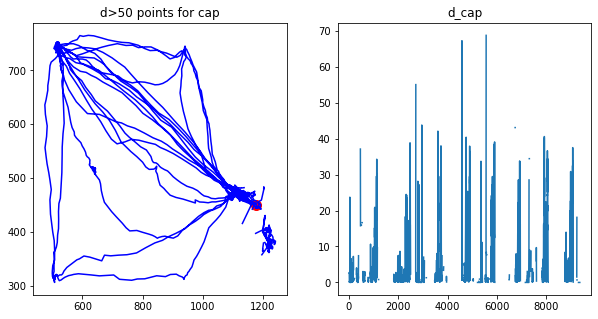

Alert: some points may still be incorrect


In [177]:
#removes freames with d_cap>50 and anything inbetween if less than 10 frames apart, sets them to NaNs and interpolates cap coordinates
more=[]
frames_to_remove=[]
remove_me=df2[df2['d_cap']>50].index.tolist()
with tqdm(total=len(df2.index)) as pbar:
    for i in list(range(len(remove_me)-1)):
        if remove_me[i+1]-remove_me[i] <= 20:
            k=1
            while remove_me[i]+k < remove_me[i+1]:
                more.append(remove_me[i]+k)
                k+=1
                frames_to_remove=remove_me+more
                pbar.update(1)
            
df2.loc[frames_to_remove, ['cap_x', 'cap_y']]=np.nan

for row in range(1,len(df2.index)):
    df2['d_cap'].iloc[row]= d_df(df2, 'cap_x','cap_y', row)

with tqdm(total=len(df2.index)) as pbar:
    for column in ['cap_x', 'cap_y']:
        for row in range(1,len(df2[column])):
            if (df2.notna().loc[row, column]) & (df2.isna().loc[row-1, column]):
                k = 1
                while (df2.notna().loc[row+k, column]) :
                    k+=1
                    if (row+k)==len(df2[column])-1:
                        k=k
                        break
                if (df2.isna().loc[row+k, column]) & (k < 25):
                    df2.loc[row:row+k, column]=np.nan
        pbar.update(1)

        
for i in list(range(5478,5700))+list(range(7285,7670)):
    df2.loc[i, ['cap_x', 'cap_y', 'tailbase_x', 'tailbase_y']]=np.nan
       
        
#at this stage, cap should be okay

fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1) 
ax.plot(df2['cap_x'], df2['cap_y'], color ='blue')
ax.scatter(df2[df2['d_cap']>50]['cap_x'], df2[df2['d_cap']>50]['cap_y'], c ='red', s=100)
ax.set_title('d>50 points for cap')

ax = fig.add_subplot(1,2,2) 
x1 = np.linspace(0.0, len(df2.index), len(df2.index))
ax.plot(x1, df2['d_cap'])
ax.set_title('d_cap')
plt.show()


if max(df2['d_cap'].dropna())>50:
    print('Alert: some points may still be incorrect')
else:
    print('Cap has converged')

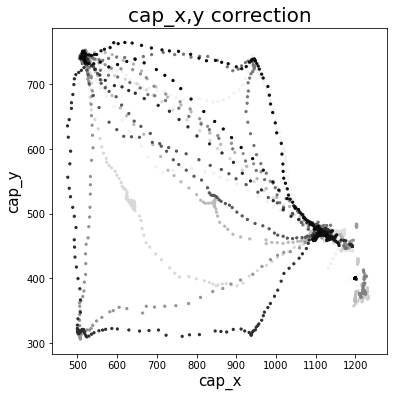

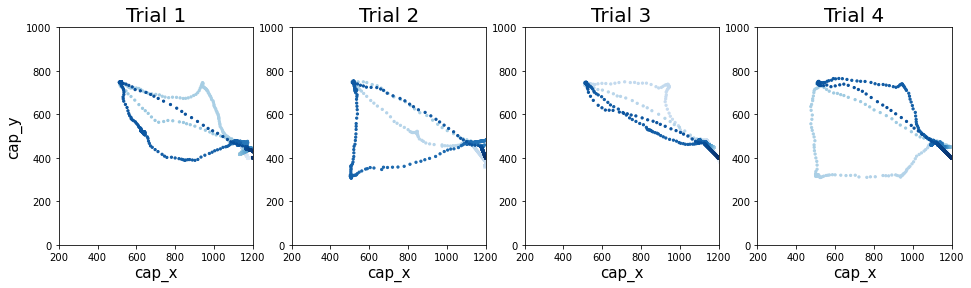

In [178]:
fig=plt.figure(figsize=(6,6))
plt.scatter(df2['cap_x'], df2['cap_y'], c =df2['Time (s)'], s=5, cmap='Greys')
plt.title("cap_x,y correction", fontsize=20)
plt.xlabel('cap_x', fontsize=15)
plt.ylabel('cap_y', fontsize=15)

fig=plt.figure(figsize=(4*len(LED_intervals[0]),4))
for trial in range(len(LED_intervals[0])):
    
    df3=df2[LED_intervals[0][trial]: LED_intervals[1][trial]].interpolate()

    ax = fig.add_subplot(1,len(LED_intervals[0]),trial+1) 
    ax.scatter(df3['cap_x'], df3['cap_y'], c =df3['Time (s)'], s=5, cmap='Blues')
    ax.set_title("Trial " + str(trial+1), fontsize=20)
    ax.set_xlim(200, 1200)
    ax.set_ylim(0, 1000)

    ax.set_xlabel('cap_x', fontsize=15)
    if trial ==0:
        ax.set_ylabel('cap_y', fontsize=15)

In [179]:
#interpolates cap
#calculates the distances of the points from cap:

df2[['cap_x', 'cap_y']]=df2[['cap_x', 'cap_y']].interpolate(method='linear')

df2['cap_Rear_distance']=df2['cap_Lear_distance']=df2['cap_tail_distance']=df['leftear_x']*0

for row in range(len(df2.index)):
    df2['cap_Lear_distance'].iloc[row]= edist_df(df2, 'leftear','cap', row)
    df2['cap_Rear_distance'].iloc[row]= edist_df(df2, 'rightear','cap', row)
    df2['cap_tail_distance'].iloc[row]= edist_df(df2, 'tailbase','cap', row)
    
#cleans ears and tail position with distance limit from cap 
#cap limit for ears=20
#cap limit for tail=50-150

R_before = df2['cap_Rear_distance'].copy()

df2['rightear_x'].mask(df2['cap_Rear_distance'] >20, np.nan, inplace=True)
df2['rightear_y'].mask(df2['cap_Rear_distance'] >20, np.nan, inplace=True)
#df2[['rightear_x', 'rightear_y']]=df2[['rightear_x', 'rightear_y']].interpolate(method='linear')

L_before=df2['cap_Lear_distance'].copy()

df2['leftear_x'].mask(df2['cap_Lear_distance'] >20, np.nan, inplace=True)
df2['leftear_y'].mask(df2['cap_Lear_distance'] >20, np.nan, inplace=True)
#df2[['leftear_x', 'leftear_y']]=df2[['leftear_x', 'leftear_y']].interpolate(method='linear')

tail_before=df2['cap_tail_distance'].copy()
    
df2['tailbase_x'].mask((df2['cap_tail_distance'] >150)|(df2['cap_tail_distance'] <50), np.nan, inplace=True)
df2['tailbase_y'].mask((df2['cap_tail_distance'] >150)|(df2['cap_tail_distance'] <50), np.nan, inplace=True)
#df2[['tailbase_x', 'tailbase_y']]=df2[['tailbase_x', 'tailbase_y']].interpolate(method='linear')

#recalculates cap-point distances for ears and d_tail, d(R/L)ear
for row in range(len(df2.index)):
    df2['cap_Rear_distance'].iloc[row]= edist_df(df2, 'rightear', 'cap', row)
    df2['cap_Lear_distance'].iloc[row]= edist_df(df2, 'leftear','cap', row)
    df2['d_Rear'].iloc[row]= d_df(df2, 'rightear_x','rightear_y', row)
    df2['d_Lear'].iloc[row]= d_df(df2, 'leftear_x', 'leftear_y', row)
    df2['d_tail'].iloc[row]= d_df(df2, 'tailbase_x','tailbase_y', row)


#further cleaning for tail: removes points with too high deviations from frame to frame

df2['tailbase_x'].mask((df2['d_tail'] >30), np.nan, inplace=True)
df2['tailbase_y'].mask((df2['d_tail'] >30), np.nan, inplace=True)


df2=df2.interpolate(method='linear')

        

for row in range(len(df2.index)):
    df2['cap_Rear_distance'].iloc[row]= edist_df(df2, 'rightear', 'cap', row)
    df2['cap_Lear_distance'].iloc[row]= edist_df(df2, 'leftear','cap', row)
    df2['d_Rear'].iloc[row]= d_df(df2, 'rightear_x','rightear_y', row)
    df2['d_Lear'].iloc[row]= d_df(df2, 'leftear_x', 'leftear_y', row)
    df2['cap_tail_distance'].iloc[row]= edist_df(df2, 'tailbase','cap', row)
    df2['d_tail'].iloc[row]= d_df(df2, 'tailbase_x','tailbase_y', row)



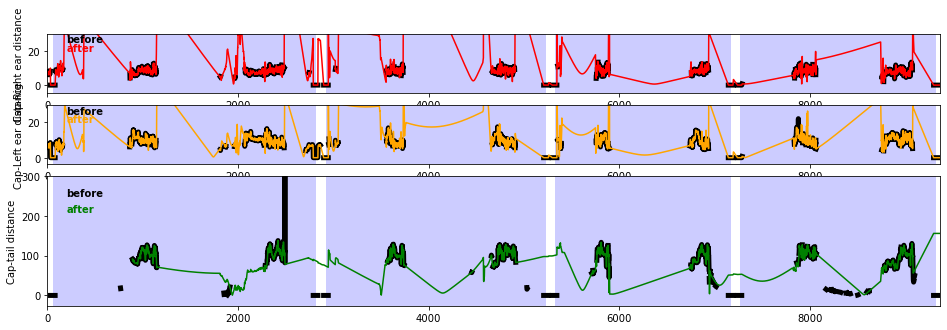

In [180]:
fig=plt.figure(figsize=(16,5))
ax=plt.subplot2grid((4, 1), (0, 0), rowspan=1)
ax.plot(R_before, color='k',linewidth=5)
ax.plot(df2['cap_Rear_distance'], color='r')
ax.set_ylabel('Cap-Right ear distance')
ax.text( 200, 25, "before", c='k', fontweight='bold', fontsize =10)
ax.text( 200, 20, "after", c='r', fontweight='bold', fontsize =10)
ax.set_ylim(top=30)
ax.set_xlim(left=0, right=len(df2.index))
for trial in range(len(LED_intervals[0])):
     ax.axvspan(LED_intervals[0][trial], LED_intervals[1][trial], facecolor='b', alpha=0.2)


ax=plt.subplot2grid((4, 1), (1, 0), rowspan=1)
ax.plot(L_before, color='k',linewidth=5)
ax.plot(df2['cap_Lear_distance'], color='orange')
ax.set_ylabel('Cap-Left ear distance')
ax.text( 200, 25, "before", c='k', fontweight='bold', fontsize =10)
ax.text( 200, 20, "after", c='orange', fontweight='bold', fontsize =10)
ax.set_ylim(top=30)
ax.set_xlim(left=0, right=len(df2.index))
for trial in range(len(LED_intervals[0])):
     ax.axvspan(LED_intervals[0][trial], LED_intervals[1][trial], facecolor='b', alpha=0.2)


ax=plt.subplot2grid((4, 1), (2, 0), rowspan=2)
ax.plot(tail_before, linewidth=5, color='k')
ax.plot(df2['cap_tail_distance'], color='green')
ax.set_ylabel('Cap-tail distance')
ax.text( 200, 250, "before", c='k', fontweight='bold', fontsize =10)
ax.text( 200, 210, "after", c='green', fontweight='bold', fontsize =10)
ax.set_ylim(top=300)
ax.set_xlim(left=0, right=len(df2.index))
for trial in range(len(LED_intervals[0])):
     ax.axvspan(LED_intervals[0][trial], LED_intervals[1][trial], facecolor='b', alpha=0.2)


plt.show(block=False)
plt.close()

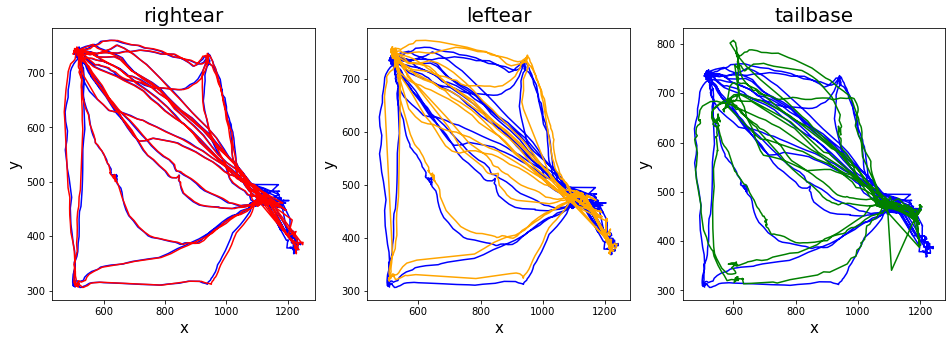

In [181]:
#Before and after cleaning graphs

fig=plt.figure(figsize=(16,5))
for i in [0,1,2]: 

    item= ['rightear', 'leftear', 'tailbase']
    colours=['red', 'orange', 'green']
    
    ax = fig.add_subplot(1,3,i+1) 
    ax.plot(df2['cap_x'], df2['rightear_y'], c ='blue')
    ax.plot(df2[str(item[i]+'_x')], df2[str(item[i]+'_y')], c =colours[i])
    ax.set_title(item[i], fontsize=20)
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)
    

plt.show(block=False)
plt.close()


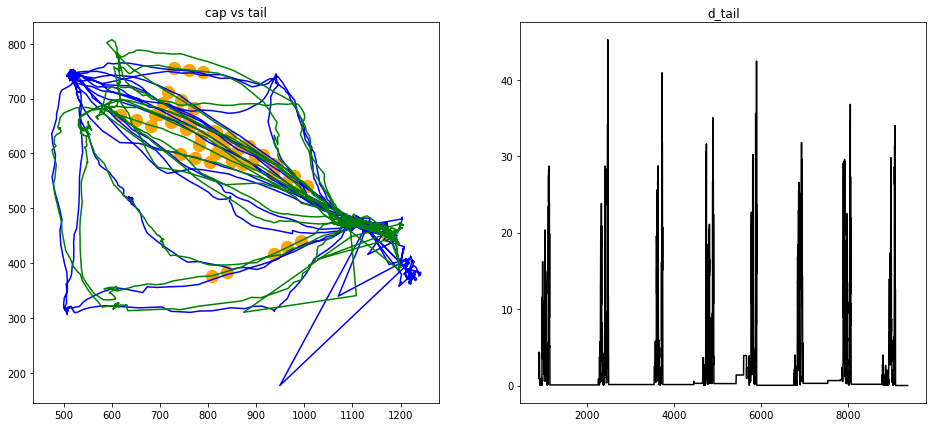

In [166]:
fig=plt.figure(figsize=(16,7))
ax=fig.add_subplot(1,2,1)
ax.plot(df2['cap_x'], df2['cap_y'], color ='blue')
ax.plot(df2['tailbase_x'], df2['tailbase_y'], color ='green')
ax.scatter(df2[df2['d_tail']>30]['tailbase_x'], df2[df2['d_tail']>30]['tailbase_y'], c ='orange', s=150)
ax.set_title('cap vs tail')
ax=fig.add_subplot(1,2,2)
ax.plot(df2['d_tail'], color='black')
ax.set_title('d_tail');
plt.show(block=False)
plt.close()

In [182]:
# export video for checking from the orginal flv
df3=df2.fillna(0)


FPS = 25

cap = cv2.VideoCapture(os.path.join(input_folder, vid_name))
width=cap.get(3)
height=cap.get(4)
fourcc=cv2.VideoWriter_fourcc(*'mp4v')

video=cv2.VideoWriter(os.path.join(output_folder,  name+"_DLC_labelled.mp4"), fourcc, int(FPS), (int(width), int(height)))

i=0
with tqdm(total=(min(len(df2.index),int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-2))) as pbar:
    for i in range(min(len(df2.index),int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-2)):
        ret, frame = cap.read()
        if i > 100:
            for k in range(i-99,i):
                frame = cv2.circle(frame, (int(df3['tailbase_x'][k]), int(df3['tailbase_y'][k])), 2, (0, 255, 0), -1)
                frame = cv2.circle(frame, (int(df3['leftear_x'][k]), int(df3['leftear_y'][k])), 2, (0, 0, 255), -1)
                frame = cv2.circle(frame, (int(df3['rightear_x'][k]), int(df3['rightear_y'][k])), 2, (255, 255, 0), -1)
                frame = cv2.circle(frame, (int(df3['cap_x'][k]), int(df3['cap_y'][k])), 3, (255, 0, 0), -1)

        newer = cv2.circle(frame, (int(df3['tailbase_x'][i]), int(df3['tailbase_y'][i])), 10, (0,  255,0), -1)    
        newer = cv2.circle(newer, (int(df3['cap_x'][i]), int(df3['cap_y'][i])), 10, (255, 0, 0), -1)
        newer = cv2.circle(newer, (int(df3['leftear_x'][i]), int(df3['leftear_y'][i])), 6, (0, 0,255), -1)
        newer = cv2.circle(newer, (int(df3['rightear_x'][i]), int(df3['rightear_y'][i])), 6, (255, 225, 0), -1)
        font = cv2.FONT_HERSHEY_SIMPLEX 
        text = str(i)
        new=cv2.putText(frame, text, (20,100) , font, 1, (0,255,0), 5)
        video.write(newer)
        pbar.update(1)

    
video.release()
cap.release()

if os.path.exists(os.path.join(output_folder,vid_name[:-4]+"_DLC_labelled.mp4")):
    print('Video saved successfully')
    

<ipython-input-182-9f612a55e148>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=(min(len(df2.index),int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-2))) as pbar:



Video saved successfully


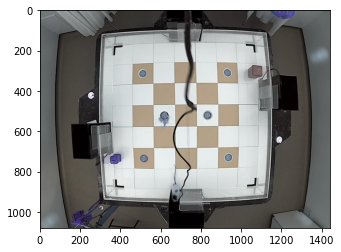

In [76]:
frames=[894,2628,2635,3981,5747,6651,6666]

for frame in frames:
    
    cap = cv2.VideoCapture(os.path.join(input_folder, vid_name))
    cap.set(1, frame+1)
    img = cap.read()[1]
    plt.imshow(img)   
    cv2.imwrite(os.path.join(output_folder, str(frame) + '.tiff'), img)

In [183]:
for i in range(len(meta)):
    df_i = df2[LED_intervals[0][i]: LED_intervals[1][i]]
    if stage=='PRE':
        stage_part=stage_name[3]
    else:
        stage_part=str(i+1)
        
    if session_type=='A':
        meta_end='N'
    elif session_type=='E':
        meta_end= meta[i]
    
    name_i= animal +"_"+ session_type + str(session_number) +"_"+ meta[i] + meta_end + sandwell[2] +"_"+ stage + stage_part +"_DLC.csv"
        
    if os.path.exists(os.path.join(output_folder, name_i)):
        print('Warning! Files already exist')
    else:
        print("Exporting ", name_i)
        df_i.to_csv(os.path.join(output_folder, name_i), sep=',')


Exporting  H2231_E34_EE5_CHO1_DLC.csv
Exporting  H2231_E34_EE5_CHO2_DLC.csv
Exporting  H2231_E34_EE5_CHO3_DLC.csv
Exporting  H2231_E34_EE5_CHO4_DLC.csv


In [ ]:

frames_coordinates= '6666...672.980.699.971..,6651...649.747.673.752..,5747...671.878.695.875..,894.666.860.673.977.705.971.690.978,2628...621.795.648.785..,[2635 4332 7897 9371].646.819.668.928.689.909.675.928,3981...675.1011.703.996..'

def get_coordinates(frame_coordinates):
    """
    frame_coordinats is a string in the format 'frame1.tailbase_x1.tailbase_y1.rightear_x1.rightear_y1.leftear_x1.leftear_y1.cap_x1.cap_x1,frame2 ... '
    
    """
    items_print=[]; caps_print=[]
    
    for sigle_frame_coordinates in frame_coordinates.split(','):
        frame, tailbase_x, tailbase_y, rightear_x, rightear_y, leftear_x, leftear_y, cap_x, cap_y = sigle_frame_coordinates.split(
        '.')
        caps=[cap_x, cap_y]
        caps_labels=['cap_x', 'cap_y']
        items= [tailbase_x, tailbase_y, rightear_x, rightear_y, leftear_x, leftear_y]
        items_labels=['tailbase_x', 'tailbase_y', 'rightear_x', 'rightear_y', 'leftear_x', 'leftear_y']
        for i in range(len(items)):
            if items[i] != '':
                    items_print.append('df2.loc[' + frame + ', \''+items_labels[i] +'\' ] =' + items[i] )
        for i in range(len(caps)):
            if items[i] != '':
                    caps_print.append('df2.loc[' + frame + ', \''+caps_labels[i] +'\' ] =' + caps[i] )
    
    for item in items_print:
        print(item)
        
    for item in caps_print:
        print(item)
        
get_coordinates(frames_coordinates)

In [ ]:
cap.release()
video.release()